<a href="https://colab.research.google.com/github/taaha3244/EuroSat-Image-Classification/blob/main/EUROSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import PIL
import os
import zipfile
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.74.201.218:8470']


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'

Archive:  /content/drive/MyDrive/archive.zip
replace EuroSAT/AnnualCrop/AnnualCrop_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
classes=os.listdir("/content/EuroSAT")
classes.pop()
print(classes)
len(classes)

['HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'Forest', 'River', 'Residential', 'PermanentCrop', 'AnnualCrop', 'SeaLake']


10

In [ ]:
import os
import shutil
import numpy as np

def split_data(source_folder, target_folder, train_size=0.7, val_size=0.2):
    # Ensure train_size and val_size sum up to less than 1
    if train_size + val_size >= 1:
        raise ValueError("train_size and val_size sum should be less than 1")

    classes = os.listdir(source_folder)
    for cls in classes:
        os.makedirs(os.path.join(target_folder, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'val', cls), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'test', cls), exist_ok=True)

        # Get a list of pictures
        all_images = os.listdir(os.path.join(source_folder, cls))
        np.random.shuffle(all_images)  # Shuffle the list

        # Calculate split indices
        train_split_index = int(len(all_images) * train_size)
        val_split_index = train_split_index + int(len(all_images) * val_size)

        # Splitting the dataset
        train_images = all_images[:train_split_index]
        val_images = all_images[train_split_index:val_split_index]
        test_images = all_images[val_split_index:]

        # Copying files to train, val, and test directories
        for image in train_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'train', cls, image)
            shutil.copyfile(source_path, dest_path)

        for image in val_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'val', cls, image)
            shutil.copyfile(source_path, dest_path)

        for image in test_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'test', cls, image)
            shutil.copyfile(source_path, dest_path)

# Usage
source_folder = '/content/EuroSAT' # Your original folder
target_folder = '/content' # Where to save the reorganized structure
split_data(source_folder, target_folder)


In [ ]:
train_data='/content/train'
test_data='/content/test'
val_data='/content/val'

In [ ]:
from torchvision import datasets, transforms


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        # transforms.Pad((80, 80, 80, 80), fill=0, padding_mode='constant'),
                                       transforms.Resize(224) ,
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                      #  transforms.Normalize([0.485, 0.456, 0.406],
                                      #                       [0.229, 0.224, 0.225])
])



test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

val_transforms=transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.label_to_idx = {}
        label_idx = 0

        # Loop through the directories in root_dir
        for subdir in next(os.walk(root_dir))[1]:
            current_dir = os.path.join(root_dir, subdir)
            self.label_to_idx[current_dir] = label_idx
            label_idx += 1

            # Loop through the files in each subdirectory
            for file in os.listdir(current_dir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(current_dir, file), self.label_to_idx[current_dir]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
train_data = CustomDataset(root_dir='/content/train', transform=train_transforms)
val_data = CustomDataset(root_dir='/content/val', transform=val_transforms)
test_data = CustomDataset(root_dir='/content/test', transform=test_transforms)

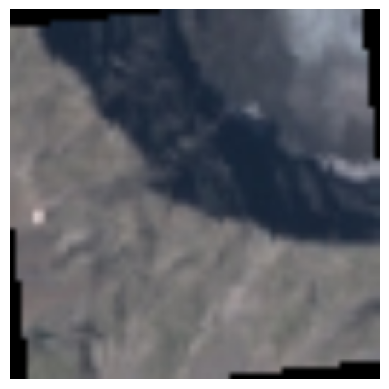

In [ ]:
img=train_data[1908][0]
img=img.numpy()
img=img.transpose(1,2,0)
plt.imshow(img)
plt.axis('Off')
plt.show()

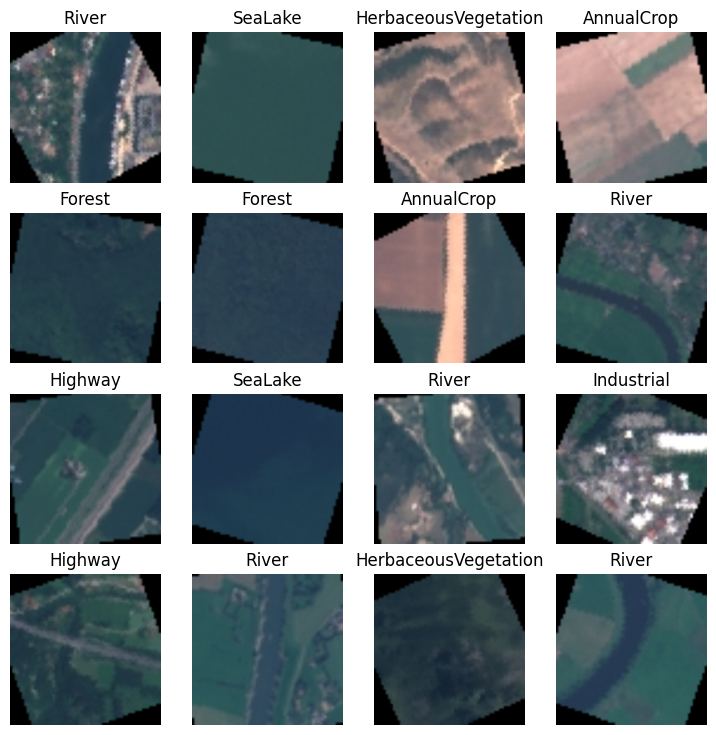

In [ ]:
# Plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    img=img.numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.transpose(1,2,0), cmap="gray")
    plt.title(classes[label])
    plt.axis(False);

In [ ]:
print(f'The length of train data is : {len(train_data)} \nThe length of val data is: {len(val_data)}\nThe length of test data is : {len(test_data)}')

The length of train data is : 18900 
The length of val data is: 5400
The length of test data is : 2700


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [ ]:
print(f'The train_dataloader has {len(train_dataloader)} batches of {len(train_dataloader)*64} images')

The train_dataloader has 296 batches of 18944 images


In [ ]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"The number of batches are :{len(train_dataloader)}")

Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])
The number of batches are :296


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Label: 1, class name is :Highway


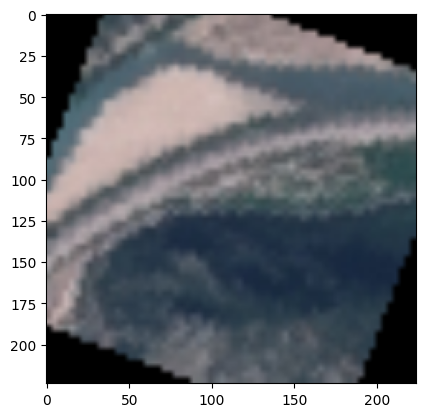

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
class_img=classes[label]
img=img.numpy()
print(f"Label: {label}, class name is :{class_img}")
plt.imshow(img.transpose(1,2,0), cmap="gray")
plt.show()

In [ ]:
from torchvision import  models
# Load pre-trained AlexNet
model = models.alexnet(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 120MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model.to(device)

Using cpu device


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torch import optim

criterion = nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss.append(running_loss / max(len(train_dataloader), 1))  # Avoid division by zero

    # Validation phase
    val_loss = 0.0
    accuracy = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model(inputs)
            batch_loss = criterion(logps, labels)

            val_loss += batch_loss.item()

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    # Print statistics
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[-1]:.3f}.. "
          f"Val loss: {val_loss/max(len(val_dataloader), 1):.3f}.. "  # Avoid division by zero
          f"Val accuracy: {accuracy/max(len(val_dataloader), 1):.3f}")

    # Clear unused memory
    if device == 'cuda':
        torch.cuda.empty_cache()
